In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential
# from keras.layers.core import Dense, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import csv
import collections
from scipy.stats import zscore
from datetime import datetime
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv('data/XAU_JPY Historical Data.csv')

In [29]:
df.head(3)

,Date,Price,Open,High,Low,Vol.,Change %
0,06/21/2024,"371,091","375,310","376,570","369,665",NaN,-1.04%
1,06/20/2024,"375,001","367,792","375,499","367,490",NaN,1.97%
2,06/19/2024,"367,743","367,756","368,548","366,889",NaN,0.03%


In [30]:
df = df.iloc[::-1] # This reverses the order of the dataframe rows

In [31]:
df.head(3)

,Date,Price,Open,High,Low,Vol.,Change %
784,06/21/2021,"196,634","194,545","196,869","194,033",NaN,1.20%
783,06/22/2021,"196,758","196,728","197,718","195,929",NaN,0.06%
782,06/23/2021,"197,276","196,809","198,813","196,643",NaN,0.26%


In [32]:
df.shape

(785, 7)

In [33]:
df = df.drop(columns=['Date','Vol.', 'Change %'])

In [34]:
df.head()

,Price,Open,High,Low
784,"196,634","194,545","196,869","194,033"
783,"196,758","196,728","197,718","195,929"
782,"197,276","196,809","198,813","196,643"
781,"196,764","197,342","198,194","196,566"
780,"197,247","196,841","197,974","196,691"


Lets take a look at closing price, its so rough

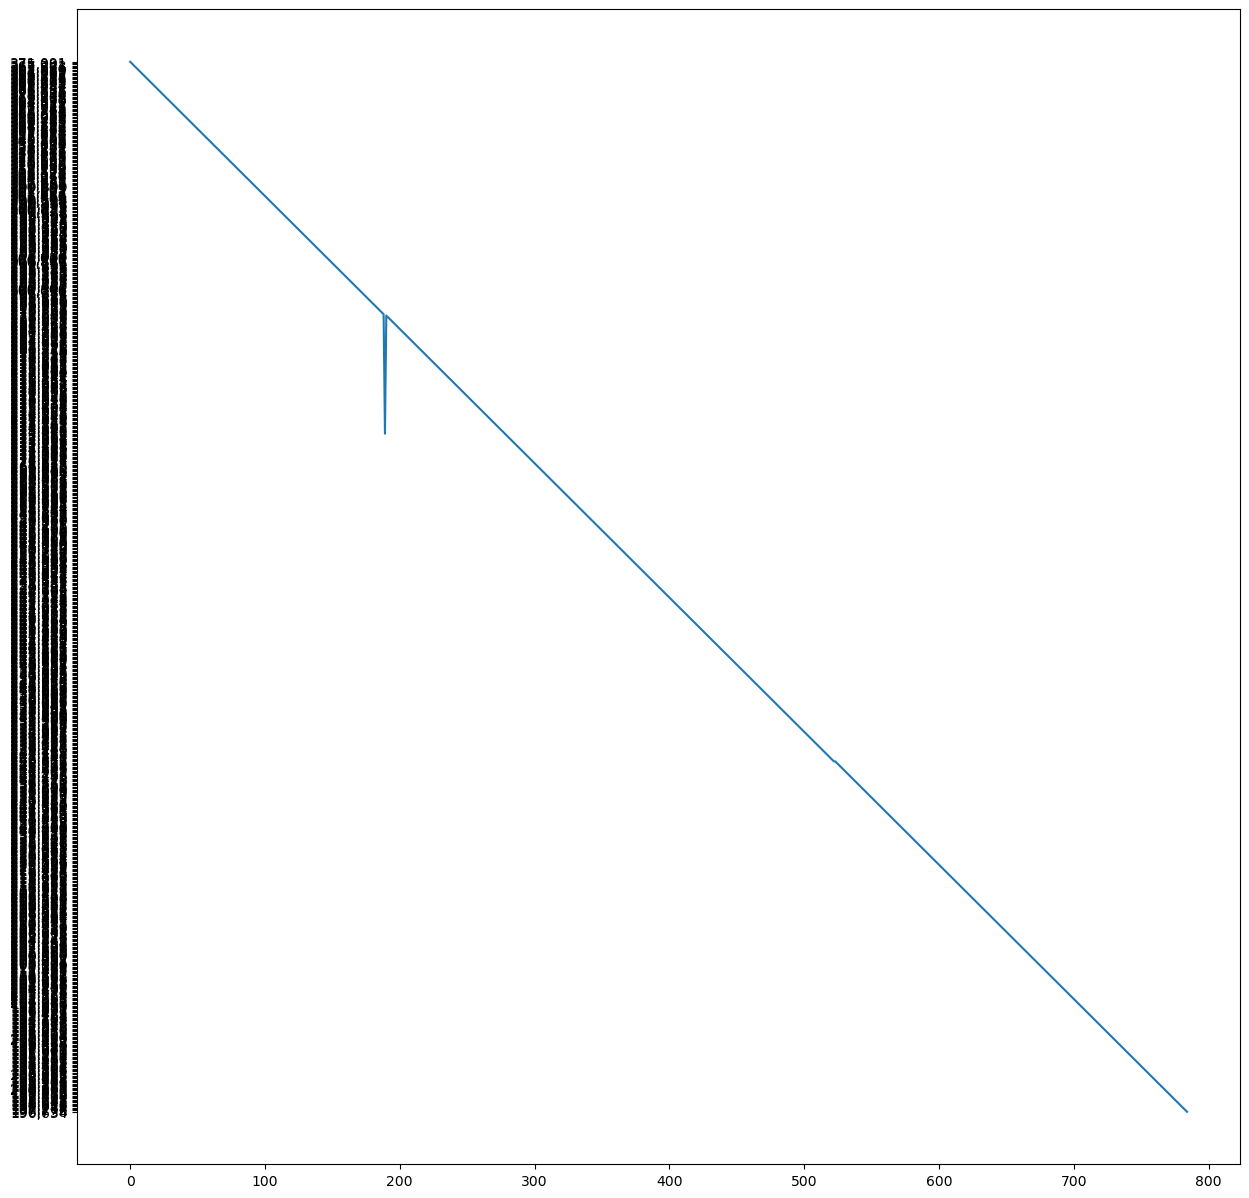

In [35]:
plt.figure(figsize=(15,15))
plt.plot(df['Price'])

In [ ]:
# Remove commas and convert to integers
df['Price'] = df['Price'].str.replace(',', '').astype(int)
df['Open'] = df['Open'].str.replace(',', '').astype(int)
df['High'] = df['High'].str.replace(',', '').astype(int)
df['Low'] = df['Low'].str.replace(',', '').astype(int)

In [ ]:
# Normalization

scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)

y_close = df[:,1]

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(y_close)
plt.show()

In [ ]:
ntrain = int(len(y_close)*0.8) 

train = df[0:ntrain]
test  = df[ntrain:len(df)]

y_close_train = y_close[0:ntrain]
y_close_test  = y_close[ntrain:len(y_close)]

In [ ]:
y_close_test.shape

## Here we construct the image

In [ ]:
import numpy as np

def to_sequences(seq_size, data,close):
    x = []
    y = []

    for i in range(len(data)-seq_size-1):
        window = data[i:(i+seq_size)]
        after_window = close[i+seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)


timesteps = 10

x_train, y_train = to_sequences(timesteps, train, y_close_train)
x_test, y_test   = to_sequences(timesteps, test, y_close_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

In [ ]:
x_train[0]

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[2], x_train.shape[1],x_train.shape[3]))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[2],x_test.shape[1],x_test.shape[3]))

In [ ]:
print(x_train.shape)

In [ ]:
x_train[0][0].shape

### Here is the image expected

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.imshow(x_train[0][0])
ax2.imshow(x_train[1][0])
ax3.imshow(x_train[2][0])
ax4.imshow(x_train[3][0])
ax5.imshow(x_train[4][0])

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(8, kernel_size = (1, 2), strides = (1, 1),  padding = 'valid', 
               activation = 'relu', input_shape = (1,10,4)))
cnn.add(MaxPooling2D(pool_size = (1,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation="relu"))
cnn.summary()   

In [ ]:
cnn.compile(loss='mean_squared_error', optimizer='nadam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1, patience=2, verbose=2, mode='auto') 
checkpointer = ModelCheckpoint(filepath="CNN_Parameters.hdf5", verbose=0, save_best_only=True) # save best model

In [ ]:
history = cnn.fit(x_train,y_train,validation_split=0.2,batch_size = 128, callbacks=[checkpointer],verbose=1,epochs = 100)

In [ ]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()

In [ ]:
cnn.load_weights('CNN_Parameters.hdf5')

pred = cnn.predict(x_test)
print(pred.shape)

In [ ]:
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("RMSE Score: {}".format(score))

In [ ]:
plt.figure(figsize=(15,15))

plt.plot(y_test, label = 'actual')
plt.plot(pred,   label = 'predicted')
plt.legend()
plt.show()